# 1. Imports

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from scikitplot.metrics import plot_confusion_matrix
import plotly
import plotly.graph_objects as go
import plotly.express as px


## Import Survey Data from URL

In [2]:
#Import dataset
url = 'https://ndownloader.figshare.com/files/18543320?private_link=74a5ea79d76ad66a8af8'

#Extract Columns
survey = pd.read_excel(url)
raw_cols = survey.columns

#Create df
df = pd.read_excel(url, header=None, skiprows = 2, names = raw_cols)

# #Set data path
# d_path = 'data/'

# #Import survey data from .csv
# df = pd.read_csv(d_path + 'nature_phdsurvey_2019.csv', low_memory = False)

# 2. Create and Clean train & test sets

## Defining a function to clean data

In [3]:
#Create function to clean data
#The data dictionary provided with the article does not match the dataset well. Check readme for explanation as to why I removed some columns. I think the question #'s got mislabeled somehow.

def clean_data(X):
    X = X.copy()
    
    print(f'The survey dataset was originally {X.shape}')
    
    #Filter out 300 rows that chose to not answer target question (those that preferred not to answer)
    X = X[((X['Q28'] == 'Yes') | (X['Q28'] == 'No'))]
    
    #Drop columns containing unique metadata for each test
    X = X.drop(columns = ['ID.format', 'ID.endDate', 'ID.completed', 'ID.site', 'ID.date', 'ID.start', 'ID.end', 'ID.time'])
    
    #Drop columns with extra / specific data. Most are a step down from 'Other' answers in survey
    X = X.drop(columns = ['Q1.a', 'Q2', 'Q3.a', 'Q6', 'Q6.a', 'Q7', 'Q7.a', 'Q8', 'Q8.a', 'Q9', 'Q9.a', 'Q10', 'Q10.a', 'Q11', 'Q11.a',
                         'Q12.a', 'Q14', 'Q14.a', 'Q15.a', 'Q15.b', 'Q15.c', 'Q15.d', 'Q15.e', 'Q15.f', 'Q15.g', 'Q15.h', 'Q15.i', 'Q15.j',
                          'Q15.k', 'Q15.l', 'Q15.m', 'Q15.n', 'Q16','Q17.a', 'Q25.a', 'Q26', 'Q29', 'Q29.a', 'Q32:1', 'Q32:2', 'Q32:3', 'Q32:4', 
                          'Q32:5', 'Q32:6', 'Q32:7', 'Q32.a', 'Q33', 'Q35:1', 'Q35:2', 'Q35:3', 'Q35:4', 'Q35:5', 'Q35:6', 'Q35:7', 'Q35:8', 'Q35:9', 
                          'Q35.a', 'Q36.a','Q37.a', 'Q37.b', 'Q37.c', 'Q37.d', 'Q37.e','Q39:1', 'Q39:2', 'Q39:3', 'Q39:4', 'Q39:5', 'Q39:6', 'Q39:7', 'Q39.a',
                          'Q39:8', 'Q39:9', 'Q39:1', 'Q39:2', 'Q39:3', 'Q39:4', 'Q39:5', 'Q39:6', 'Q39:7', 'Q39:8', 'Q39:9','Q39.a', 'Q40.a', 'Q41', 'Q44', 'Q44.a', 
                          'Q45:1', 'Q45:2', 'Q45:3', 'Q45:4', 'Q45:5', 'Q45:6', 'Q45:7', 'Q45:8', 'Q45:9', 'Q45:10', 'Q45:11', 'Q45.a', 'Q46:1', 'Q46:2', 'Q46:3', 'Q46:4', 'Q46:5', 'Q46:6', 'Q46:7', 'Q46:8', 'Q46:9', 'Q46:10', 'Q46:11', 'Q46:12', 
                          'Q46:13', 'Q46:14', 'Q46.a', 'Q48:1', 'Q48:2', 'Q48:3', 'Q59:5', 'Q59.a', 'Q60', 'Q61', 'Q62', 'Q63', 'Q64', 'Q65.a', 'Q65.b',
                          'Q48:4', 'Q48:5', 'Q48:6', 'Q48:7', 'Q48.a', 'Q49:8', 'Q49.a', 'Q52.a', 'Q53:1', 'Q53:2', 'Q53:3', 'Q53:4', 'Q53:5', 'Q53:6', 'Q53:7', 
                          'Q53.a', 'Q54:5', 'Q54.a', 'Q55', 'Q58.a', 'Q59:1', 'Q59:2', 'Q59:3', 'Q47.a'])
    
    #Q3 Replace 'Other, please specify with other'
    X['Q3'] = X['Q3'].replace('Other, please specify', 'Other')
    
    #Q4: Are you studying where you grew up?
    X['Q4'] = X['Q4'].replace('yes', 1)
    X['Q4'] = X['Q4'].replace('no', 0)
    
    #Q12:1-:12 1 or 0 if they went to graduate school for this reason
    Q12_ans = ['Q12:1', 'Q12:2', 'Q12:3', "Q12:4", 'Q12:5', 'Q12:6', 'Q12:7', 'Q12:8', 'Q12:9', 'Q12:10', 'Q12:11']
    for i in Q12_ans:
        X[i].fillna(0, inplace= True)
    X['Q12:1'] = (X['Q12:1'].replace('To study at a specific university', 1))
    X['Q12:2'] = (X['Q12:2'].replace('Lack of quality PhD programmes in my home country', 1))
    X['Q12:3'] = (X['Q12:3'].replace('Lack of funding opportunities in my home country', 1))
    X['Q12:4'] = (X['Q12:4'].replace('Lack of PhD programmes in my subject of choice', 1))
    X['Q12:5'] = (X['Q12:5'].replace('Chance to pursue a specific research question', 1))
    X['Q12:6'] = (X['Q12:6'].replace('Higher salaries post-study', 1))
    X['Q12:7'] = (X['Q12:7'].replace('More job opportunities post-study', 1))
    X['Q12:8'] = (X['Q12:8'].replace('Family reasons', 1))
    X['Q12:9'] = (X['Q12:9'].replace('To experience another culture', 1))
    X['Q12:10'] = (X['Q12:10'].replace('Political reasons', 1))
    X['Q12:11'] = (X['Q12:11'].replace('Other, please specify', 1))
    
    #Q18a - How satisfied are you with your decision to pursue a phd?
    X['Q18.a'] = (X['Q18.a'].replace('Neither satisfied nor dissatisfied', 'Neither'))
    
    #Q19a - How satisfied are you with your phd experience?
    X['Q19.a'] = (X['Q19.a'].replace('4 = Neither satisfied nor dissatisfied', 4))
    X['Q19.a'] = (X['Q19.a'].replace('1 = Not at all satisfied', 1))
    X['Q19.a'] = (X['Q19.a'].replace('7 = Extremely satisfied', 7))
    
    #Q21a:i & Q22a:i - How satisfied are you with x (Ordinal)
    q_21s = ['Q21.a', 'Q21.b', 'Q21.c', 'Q21.d', 'Q21.e', 'Q21.f', 'Q21.g', 'Q21.h', 'Q21.i', 'Q22.a', 'Q22.b', 'Q22.c', 'Q22.d', 'Q22.e', 'Q22.f', 'Q22.g', 'Q22.h', 'Q22.i']
    for every in q_21s:
        X[q_21s] = (X[q_21s].replace('4 = Neither satisfied nor dissatisfied', 4))
        X[q_21s] = (X[q_21s].replace('1 = Not at all satisfied', 1))
        X[q_21s] = (X[q_21s].replace('7 = Extremely satisfied', 7))
        
    #Q24 Workload on average (Ordinal)
    X['Q24'] = (X['Q24'].replace('41-50 hours','41-50'))
    X['Q24'] = (X['Q24'].replace('51-60 hours','51-60'))
    X['Q24'] = (X['Q24'].replace('61-70 hours','61-70'))
    X['Q24'] = (X['Q24'].replace('71-80 hours','71-80'))
    X['Q24'] = (X['Q24'].replace('21-30 hours','21-30'))
    X['Q24'] = (X['Q24'].replace('31-40 hours','31-40'))
    X['Q24'] = (X['Q24'].replace('Less than 11 hours','0-10'))
    X['Q24'] = (X['Q24'].replace('More than 80 hours','81 and up'))
    
    #Q25.a - extra for other
    X['Q25'] = (X['Q25'].replace('Other, please specify', 'Other'))
    
    #Q30.a - Q30.f - strongly agree or disagree
    X['Q30.a'] = (X['Q30.a'].replace('Neither satisfied nor dissatisfied', 'Neither'))
    X['Q30.b'] = (X['Q30.b'].replace('Neither satisfied nor dissatisfied', 'Neither'))
    X['Q30.c'] = (X['Q30.c'].replace('Neither satisfied nor dissatisfied', 'Neither'))
    X['Q30.d'] = (X['Q30.d'].replace('Neither satisfied nor dissatisfied', 'Neither'))
    X['Q30.e'] = (X['Q30.e'].replace('Neither satisfied nor dissatisfied', 'Neither'))
    X['Q30.f'] = (X['Q30.f'].replace('Neither satisfied nor dissatisfied', 'Neither'))

    #Q34 Did you feel discriminated against or harassed? No issue
    X['Q34'].fillna('Prefer not to say', inplace=True)
    
    #Q47 : Which of these are most difficult based on your discipline
    X['Q47:1'] = (X['Q47:1'].replace('Learning what career possibilities exist', 1))
    X['Q47:2'] = (X['Q47:2'].replace('Finding research careers within academia', 1))
    X['Q47:3'] = (X['Q47:3'].replace('Finding research careers within industry', 1))
    X['Q47:4'] = (X['Q47:4'].replace('Finding research careers within government', 1))
    X['Q47:5'] = (X['Q47:5'].replace('Finding research careers within charity/non-profit', 1))
    X['Q47:6'] = (X['Q47:6'].replace('Obtaining skills for careers in industry', 1))
    X['Q47:7'] = (X['Q47:7'].replace('Obtaining skills for careers in non-profits \xa0', 1))
    X['Q47:8'] = (X['Q47:8'].replace('Finding non-research careers that use my skills', 1))
    X['Q47:1'].fillna(0, inplace= True)
    X['Q47:2'].fillna(0, inplace= True)
    X['Q47:3'].fillna(0, inplace= True)
    X['Q47:4'].fillna(0, inplace= True)
    X['Q47:5'].fillna(0, inplace= True)
    X['Q47:6'].fillna(0, inplace= True)
    X['Q47:7'].fillna(0, inplace= True)
    X['Q47:8'].fillna(0, inplace= True)
    
    #Q49 - Which of the following do you think is needed
    X['Q49:1'].fillna(0, inplace= True)
    X['Q49:2'].fillna(0, inplace= True)
    X['Q49:3'].fillna(0, inplace= True)
    X['Q49:4'].fillna(0, inplace= True)
    X['Q49:5'].fillna(0, inplace= True)
    X['Q49:6'].fillna(0, inplace= True)
    X['Q49:1'] = (X['Q49:1'].replace('Lower competition for grants', 1))
    X['Q49:2'] = (X['Q49:2'].replace('Mentorship with individuals in my field/department/institution', 1))
    X['Q49:3'] = (X['Q49:3'].replace('Gender-specific mentorship with individuals in my field/department/institution', 1))
    X['Q49:4'] = (X['Q49:4'].replace('Better data/information about available career opportunities', 1))
    X['Q49:5'] = (X['Q49:5'].replace('A record of, or data on, career paths of previous graduates from my programme', 1))
    X['Q49:6'] = (X['Q49:6'].replace('More jobs in academia', 1))
    X['Q49:7'] = (X['Q49:7'].replace('Grants to help PhD holders transition to permanent positions', 1))
    
    #Q52:1 - 52:8 Which, if any, of the following activities have you done to advance your career? 
    X['Q52:1'].fillna(0, inplace= True)
    X['Q52:2'].fillna(0, inplace= True)
    X['Q52:3'].fillna(0, inplace= True)
    X['Q52:4'].fillna(0, inplace= True)
    X['Q52:5'].fillna(0, inplace= True)
    X['Q52:6'].fillna(0, inplace= True)
    X['Q52:7'].fillna(0, inplace= True)
    X['Q52:8'].fillna(0, inplace= True)
    X['Q52:1'] = (X['Q52:1'].replace('Attended career seminars and/or workshops',1)) 
    X['Q52:2'] = (X['Q52:2'].replace('Attended networking events',1))
    X['Q52:3'] = (X['Q52:3'].replace('Developed my social media profile',1))
    X['Q52:4'] = (X['Q52:4'].replace('Worked out an individualized development plan',1))
    X['Q52:5'] = (X['Q52:5'].replace('Discussed my career future with a supervisor/PI',1))
    X['Q52:6'] = (X['Q52:6'].replace('Discussed my career future with a mentor',1))
    X['Q52:7'] = (X['Q52:7'].replace('Discussed my career future with a careers counsellor at my institution',1))
    X['Q52:8'] = (X['Q52:8'].replace('Other, please specify',1))
    
    #Q54:1	Q54:2 Q54:3 Q54:4 Q54:5 Q54.a what would you do differently
    X['Q54:1'].fillna(0, inplace= True)
    X['Q54:2'].fillna(0, inplace= True)
    X['Q54:3'].fillna(0, inplace= True)
    X['Q54:4'].fillna(0, inplace= True)
    X['Q54:1'] = (X['Q54:1'].replace('Change area of study',1))
    X['Q54:2'] = (X['Q54:2'].replace('Change supervisor/PI ',1))
    X['Q54:3'] = (X['Q54:3'].replace('Not pursue a PhD at all',1))
    X['Q54:4'] = (X['Q54:4'].replace('Nothing',1))

    #Q58
    X['Q58:1'].fillna(0, inplace= True)
    X['Q58:2'].fillna(0, inplace= True)
    X['Q58:3'].fillna(0, inplace= True)
    X['Q58:4'].fillna(0, inplace= True)
    X['Q58:5'].fillna(0, inplace= True)
    X['Q58:6'].fillna(0, inplace= True)
    X['Q58:7'].fillna(0, inplace= True)
    X['Q58:8'].fillna(0, inplace= True)
    X['Q58:9'].fillna(0, inplace= True)
    X['Q58:10'].fillna(0, inplace= True)
    X['Q58:11'].fillna(0, inplace= True)
    X['Q58:12'].fillna(0, inplace= True)
    X['Q58:1'] = (X['Q58:1'].replace('Caucasian',1))
    X['Q58:2'] = (X['Q58:2'].replace('Latino/Hispanic',1))
    X['Q58:3'] = (X['Q58:3'].replace('Middle Eastern',1))
    X['Q58:4'] = (X['Q58:4'].replace('African',1))
    X['Q58:5'] = (X['Q58:5'].replace('Caribbean',1))
    X['Q58:6'] = (X['Q58:6'].replace('South Asian',1))
    X['Q58:7'] = (X['Q58:7'].replace('East Asian',1))
    X['Q58:8'] = (X['Q58:8'].replace('Pacific Islander',1))
    X['Q58:9'] = (X['Q58:9'].replace('American Indian',1))
    X['Q58:10'] = (X['Q58:10'].replace('Mixed ethnicity',1))
    X['Q58:11'] = (X['Q58:11'].replace('Other, please specify',1))
    X['Q58:12'] = (X['Q58:12'].replace('Prefer not to say',1))

    #Q59
    X['Q59:4'] = X['Q59:4'].replace('No', 0)
    X['Q59:4'].fillna(1, inplace= True)
    
    #Print out new shape after wrangling
    print(f'After wrangling, the dataset is {X.shape}')

    return X

## Create train/test sets, X feature matrix, and y target vector

In [4]:
train, test = train_test_split(df,train_size = 0.9, random_state = 42)
train, val = train_test_split(train, random_state =42)

## Clean training and validation sets

In [5]:
#Create dataframe from raw data
train = clean_data(train)
val = clean_data(val)

The survey dataset was originally (4597, 274)
After wrangling, the dataset is (4393, 126)
The survey dataset was originally (1533, 274)
After wrangling, the dataset is (1464, 126)


## Create feature matrix and target vector

In [6]:
#Creating X_test, y_test from features, target
X_train = train.drop(columns='Q28')
features = X_train.columns.tolist()
target = 'Q28'
y_train = train[target]
X_val = val.drop(columns='Q28')
y_val = val[target]

print(f'The shape of X_test is {X_train.shape}')
print(f'The shape of y_test is {y_train.shape}')
print(f'The model will be built to predict whether an individual will reach out for help with anxiety and depression ({target})')
print(f'The shape of X_test is {X_val.shape}')
print(f'The shape of y_test is {y_val.shape}')

The shape of X_test is (4393, 125)
The shape of y_test is (4393,)
The model will be built to predict whether an individual will reach out for help with anxiety and depression (Q28)
The shape of X_test is (1464, 125)
The shape of y_test is (1464,)


# 3. Baseline Estimate

In [7]:
# #Sklearn baseline (sklearn dummyclassifier)

# X_baseline = train.drop(columns='Q28')
# y_baseline = train['Q28']

# #Create baseline model
# baseline = DummyClassifier(strategy='most_frequent')
# baseline.fit(X_baseline, y_baseline)


# baseline.score(X_baseline, y_baseline)

# 3. Linear Model - Logistic Regression

In [8]:
# #Create logistic regression baseline
# log_pipeline = make_pipeline(
#     SimpleImputer(strategy='most_frequent'),
#     ce.OrdinalEncoder(),
#     LogisticRegression(solver = 'lbfgs',n_jobs = -1, random_state = 42, max_iter = 1000, verbose = 5)
# )

# log_model = log_pipeline.fit(X_train, y_train)
# print('Logistic baseline accuracy:', log_model.score(X_train, y_train))

# 4. Build Multiple Decision Tree or Tree Ensemble Models

### Random Forest model

In [9]:
# #Create random forest pipeline
# rf = make_pipeline(
#     SimpleImputer(strategy='most_frequent'),
#     ce.OrdinalEncoder(),
#     RandomForestClassifier(random_state = 42, n_jobs = -1)
# )

# param_distributions = {
#     'randomforestclassifier__n_estimators': [10, 50, 100, 300, 500],
#     'randomforestclassifier__max_depth': [5, 8, 10, 15, 20, None], 
#     'randomforestclassifier__min_samples_split' : [2, 5, 10, 15, 25, 100],
#     'randomforestclassifier__max_features': uniform(0, 1),
#     'randomforestclassifier__min_samples_leaf' : [1, 2, 5, 7, 10]
# }

# # If you're on Colab, decrease n_iter & cv parameters
# search = RandomizedSearchCV(
#     rf, 
#     param_distributions=param_distributions, 
#     n_iter=15, 
#     cv=15, 
#     scoring='accuracy', 
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-2
# )

# search.fit(X_train, y_train);

# print('Best hyperparameters', search.best_params_)
# print('Cross-validation Accuracy', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 0.32400636870099186, 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__min_samples_split': 15, 'randomforestclassifier__n_estimators': 300}
Cross-validation Accuracy -0.6819940814932848

In [10]:
# #Run model with selected hyperparameters
# #Create random forest model to find permutation importances
# rfpl = make_pipeline(
#     SimpleImputer(strategy='most_frequent'),
#     ce.OrdinalEncoder(),
#     RandomForestClassifier(max_depth=None, max_features=0.3,n_estimators=300,min_samples_split=15, min_samples_leaf=5, random_state = 42, n_jobs = -1)
# )

# rfpl.fit(X_train, y_train)
# pipe_score = rfpl.score(X_val, y_val)
# print(f'Validation accuracy: {pipe_score}')

### xgboost Model

In [11]:
# #Create XGBoost
# xg = make_pipeline(
#     SimpleImputer(strategy='most_frequent'),
#     ce.OrdinalEncoder(),
#     XGBClassifier(random_state = 42)
# )

# param_distributions = {
#     'xgbclassifier__n_estimators': [10, 50, 100, 300, 500],
#     'xgbclassifier__max_depth': [3, 5, 7, 10, 15], 
#     'xgbclassifier__subsample' : [0.5, 0.75, 1],
#     'xgbclassifier__colsample_bytree': [0.5, 0.75, 1],
#     'xgbclassifier__eta' : [0.01, 0.05, 0.1, 0.15, 0.2, 0.25],
#     'xgbclassifier__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
# }

# # If you're on Colab, decrease n_iter & cv parameters
# search = RandomizedSearchCV(
#     xg, 
#     param_distributions=param_distributions, 
#     n_iter=15, 
#     cv=15,
#     verbose=10, 
#     return_train_score=True, 
#     n_jobs=-2
# )

# search.fit(X_train, y_train);

# print('Best hyperparameters', search.best_params_)
# print('Cross-validation Accuracy', -search.best_score_)

Best hyperparameters {'xgbclassifier__subsample': 0.75, 'xgbclassifier__n_estimators': 100, 'xgbclassifier__max_depth': 3, 'xgbclassifier__colsample_bytree': 0.5}
Cross-validation Accuracy -0.6947416344183929

In [12]:
#Run model with selected hyperparameters
#Create xgboost model to find permutation importances
xgbpl = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ce.OrdinalEncoder(),
    XGBClassifier(reg_alpha= 1e-05, eta= 0.15, subsample = 0.75, n_estimators = 50, max_depth = 3, colsample_bytree = 1, random_state = 42)
)

xgbpl.fit(X_train, y_train)
pipe_score = xgbpl.score(X_val, y_val)
print(f'Validation accuracy: {pipe_score}')

Validation accuracy: 0.6953551912568307


## Test Set Score

In [13]:
# RF Model on Test set
test = clean_data(test)
X_test = test.drop(columns='Q28')
y_test = test[target]

The survey dataset was originally (682, 274)
After wrangling, the dataset is (655, 126)


In [14]:
test_score = xgbpl.score(X_test, y_test)
print(f'Validation accuracy: {test_score}')

Validation accuracy: 0.683969465648855


# Visualizations

## 1. Permutation performance for xgboost

In [15]:
#Run model with selected hyperparameters
#Create rf model to find permutation importances
transfrmr = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    ce.OrdinalEncoder()
)
X_train_transformed = transfrmr.fit_transform(X_train)
X_val_transformed = transfrmr.fit_transform(X_val)

xg = XGBClassifier(subsample = 0.75, n_estimators =100, max_depth = 3, colsample_bytree = 0.5, random_state = 42)
xg.fit(X_train_transformed, y_train)
pipe_score = xg.score(X_val_transformed, y_val)
print(f'Validation accuracy: {pipe_score}')

Validation accuracy: 0.6967213114754098


In [16]:
# #Build permuter
# permuter = PermutationImportance(
#     xgbpl,
#     scoring='accuracy',
#     n_iter=5,
#     random_state=42
# )

# permuter.fit(X_val_transformed, y_val)

In [17]:
# #Display permutation importances
# feature_names = X_val.columns.tolist()
# eli5.show_weights(
#     permuter,
#     top = 20,
#     feature_names= feature_names
# )

## 2. Shapley Values for Myself

## 3. Confusion Matrix

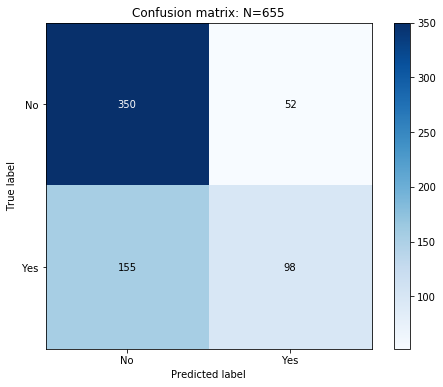

In [18]:
y_pred = xgbpl.predict(X_test)

plot_confusion_matrix(y_test, y_pred,
                     figsize = (8,6),
                      title = f'Confusion matrix: N={len(y_test)}',
                      normalize = False);

## 4. Target distribution

In [91]:
vis_data = df.copy()
vis_data = vis_data[((vis_data['Q28'] == 'Yes') | (vis_data['Q28'] == 'No'))]
q28_yes = vis_data.copy()
q28_no = vis_data.copy()
q28_yes = q28_yes['Q28']
q28_yes.replace('Yes', 1, inplace = True)
q28_yes.replace('No', 0, inplace = True)
q28_no = q28_no['Q28']
q28_no.replace('Yes', 0, inplace = True)
q28_no.replace('No', 1, inplace = True)

q28_no_s = q28_no.sum()
q28_yes_s = q28_yes.sum()
q28_sums = [q28_no_s, q28_yes_s]

q28_no = (q28_no.sum()/len(vis_data['Q28'])*100)
q28_yes = (q28_yes.sum()/len(vis_data['Q28'])*100)

target_bar = pd.DataFrame(pd.Series({'Yes' : q28_yes,
                                     'No' : q28_no}))

target_bar = target_bar.reset_index()
target_bar = target_bar.rename(columns={"index" : "choice",
                                       0 : "number"})


fig = px.bar(target_bar, x="choice", y="number",
            labels = {'choice' : 'Sought Help for Anxiety or Depression',
                     'number': 'Percent Students'}, height = 400, width = 550)
fig.update_layout( title={
        'text': 'Seeking Help for Anxiety or Depression Among Ph.D. Students',
        'x' : 0.5,
        'xanchor': "center",
        'yanchor': 'top'},
             font=dict(
        family="Droid Sans",
        size=14,
        color="#000000"))
fig.show()

In [64]:
q28_sums

[4083, 2429]

In [34]:
# q28_no = vis_data['Q28']
# q28_no.replace('No', 1, inplace = True)
# q28_no.replace('Yes', 0, inplace = True)
# q28_no = q28_no.sum()
# q28_yes = q28_yes.sum()

In [41]:
q28_no, q28_yes

(4083, 2429)

## 5. Important Feature 1 graph

## 6. PDP for Feature 1